# Series 03: SVM

In [2]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import joblib

In [25]:
tuning_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.93)),
    ('svm', SVC(probability=True))])

In [21]:
def prepare_data(data_path):
    df = pd.read_csv(data_path)
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    return X, y

In [59]:
def plot_results(res):
    df = pd.DataFrame(res)
    df['mean_test_log_loss'] = -1 * df['mean_test_log_loss']
    df_rbf = df[df['param_svm__kernel'] == 'rbf']
    df_lin = df[df['param_svm__kernel'] == 'linear'].sort_values(by='param_svm__C')
    C_values_lin = df_lin['param_svm__C'].astype(float)

    plt.figure(figsize=(8, 5))
    for gamma in sorted(df_rbf['param_svm__gamma'].unique()):
        subset = df_rbf[df_rbf['param_svm__gamma'] == gamma].sort_values(by='param_svm__C')
        C_values = subset['param_svm__C'].astype(float)
        plt.plot(C_values, subset['mean_test_acc'], marker='o', linestyle='-',
                label=f'RBF (gamma={gamma})')
        
    if not df_lin.empty:
        C_values_lin = df_lin['param_svm__C'].astype(float)
        plt.plot(C_values_lin, df_lin['mean_test_acc'], marker='s', linestyle='--', color='black',
                label='Linear')


    plt.xscale('log')
    plt.xlabel('C')
    plt.ylabel('Accuracy')
    plt.title('SVM Accuracy vs C (RBF grouped by gamma, Linear shown separately)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(8, 5))
    for gamma in sorted(df_rbf['param_svm__gamma'].unique()):
        subset = df_rbf[df_rbf['param_svm__gamma'] == gamma].sort_values(by='param_svm__C')
        C_values = subset['param_svm__C'].astype(float)
        plt.plot(C_values, subset['mean_test_log_loss'], marker='x', linestyle='--',
                label=f'RBF (gamma={gamma})')
    if not df_lin.empty:
        C_values_lin = df_lin['param_svm__C'].astype(float)
        plt.plot(C_values_lin, df_lin['mean_test_acc'], marker='s', linestyle='--', color='black',
                label='Linear')
    plt.xscale('log')
    plt.xlabel('C')
    plt.ylabel('Log Loss')
    plt.title('SVM Log Loss vs C (RBF grouped by gamma, Linear shown separately)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [22]:
X_train, y_train = prepare_data("/Users/nathanwegmann/Documents/UNIFR/MA/SP25/SP25_PR/group_project/FS-2025-Pattern-Recognition/data/train.csv")
X_test, y_test = prepare_data("/Users/nathanwegmann/Documents/UNIFR/MA/SP25/SP25_PR/group_project/FS-2025-Pattern-Recognition/data/test.csv")
X_smaller, _, y_smaller, _ = train_test_split(X_train, y_train, train_size = 0.4, stratify=y_train, random_state=42)

In [29]:
def find_best_params(X_train, y_train, param_grid = None, train_size = 0.2):
    X_tune, _, y_tune, _ = train_test_split(X_train, y_train, train_size = train_size, stratify=y_train, random_state=42)
    grid = GridSearchCV(tuning_pipeline, param_grid, cv=3, verbose=2, scoring={'acc': 'accuracy', 'log_loss': 'neg_log_loss'},refit='acc')
    grid.fit(X_tune, y_tune)
    results = grid.cv_results_
    accuracies = results['mean_test_acc']
    losses = -1 * results['mean_test_log_loss']
    for params, acc, loss in zip(results['params'], accuracies, losses):
        print(f"Params: {params} => Accuracy: {acc:.4f}, Log Loss: {loss:.4f}")
    print("\nBest parameters (based on accuracy):", grid.best_params_)
    return grid.cv_results_

In [30]:
param1={
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': [0.01, 0.001]
}

In [31]:
res1 = find_best_params(X_train=X_train, y_train=y_train, param_grid=param1)
print(res1)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END ....svm__C=0.1, svm__gamma=0.01, svm__kernel=linear; total time=   4.6s
[CV] END ....svm__C=0.1, svm__gamma=0.01, svm__kernel=linear; total time=   4.4s
[CV] END ....svm__C=0.1, svm__gamma=0.01, svm__kernel=linear; total time=   4.5s
[CV] END .......svm__C=0.1, svm__gamma=0.01, svm__kernel=rbf; total time=  38.5s
[CV] END .......svm__C=0.1, svm__gamma=0.01, svm__kernel=rbf; total time=  38.5s
[CV] END .......svm__C=0.1, svm__gamma=0.01, svm__kernel=rbf; total time=  38.4s
[CV] END ...svm__C=0.1, svm__gamma=0.001, svm__kernel=linear; total time=   4.7s
[CV] END ...svm__C=0.1, svm__gamma=0.001, svm__kernel=linear; total time=   4.6s
[CV] END ...svm__C=0.1, svm__gamma=0.001, svm__kernel=linear; total time=   4.6s
[CV] END ......svm__C=0.1, svm__gamma=0.001, svm__kernel=rbf; total time=  22.4s
[CV] END ......svm__C=0.1, svm__gamma=0.001, svm__kernel=rbf; total time=  21.3s
[CV] END ......svm__C=0.1, svm__gamma=0.001, svm

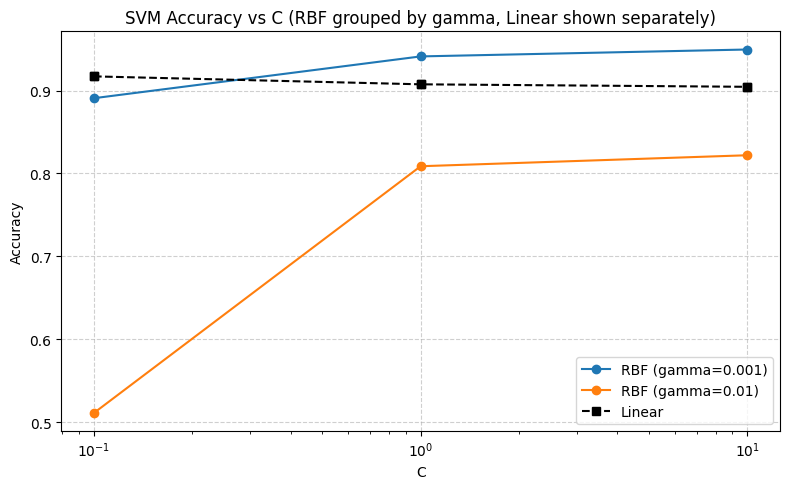

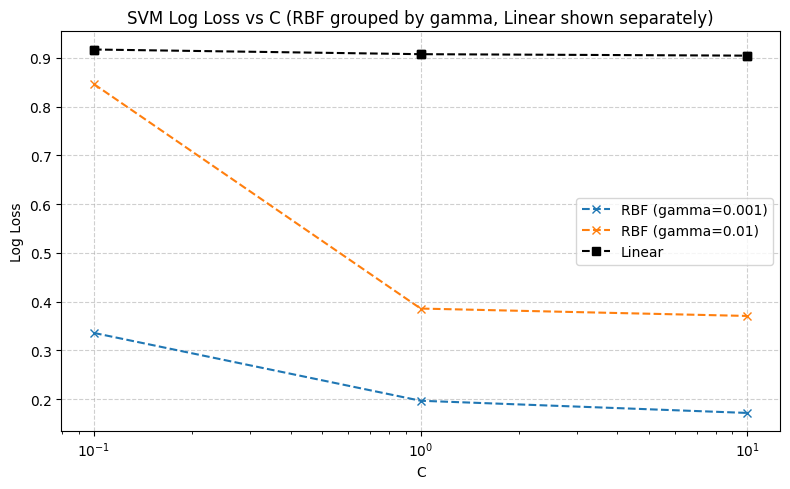

In [60]:
plot_results(res1)

In [52]:
param2={
      'svm__kernel': ['rbf'],
      'svm__C': [5,  10, 20],
      'svm__gamma': [5e-4, 0.001, 0.002],
}

In [53]:
res2 = find_best_params(X_train=X_train, y_train=y_train, param_grid=param2)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END .......svm__C=5, svm__gamma=0.0005, svm__kernel=rbf; total time=   8.1s
[CV] END .......svm__C=5, svm__gamma=0.0005, svm__kernel=rbf; total time=   8.2s
[CV] END .......svm__C=5, svm__gamma=0.0005, svm__kernel=rbf; total time=   8.0s
[CV] END ........svm__C=5, svm__gamma=0.001, svm__kernel=rbf; total time=   9.3s
[CV] END ........svm__C=5, svm__gamma=0.001, svm__kernel=rbf; total time=   9.2s
[CV] END ........svm__C=5, svm__gamma=0.001, svm__kernel=rbf; total time=   9.2s
[CV] END ........svm__C=5, svm__gamma=0.002, svm__kernel=rbf; total time=  12.9s
[CV] END ........svm__C=5, svm__gamma=0.002, svm__kernel=rbf; total time=  12.3s
[CV] END ........svm__C=5, svm__gamma=0.002, svm__kernel=rbf; total time=  12.2s
[CV] END ......svm__C=10, svm__gamma=0.0005, svm__kernel=rbf; total time=   7.6s
[CV] END ......svm__C=10, svm__gamma=0.0005, svm__kernel=rbf; total time=   7.6s
[CV] END ......svm__C=10, svm__gamma=0.0005, svm_

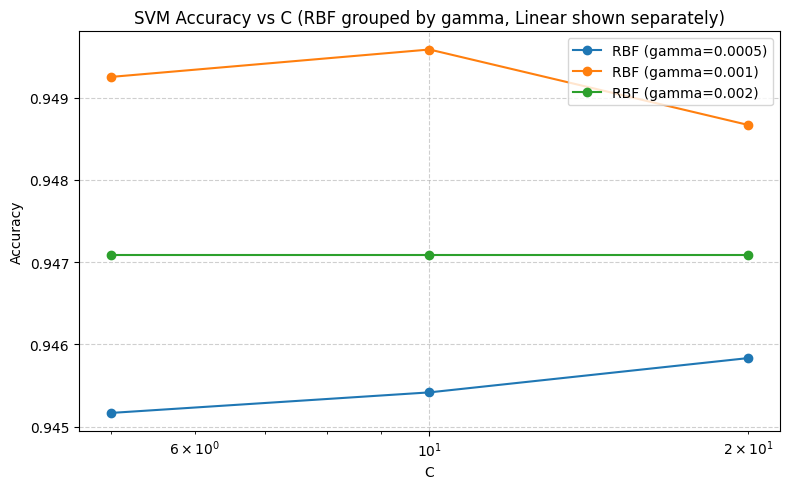

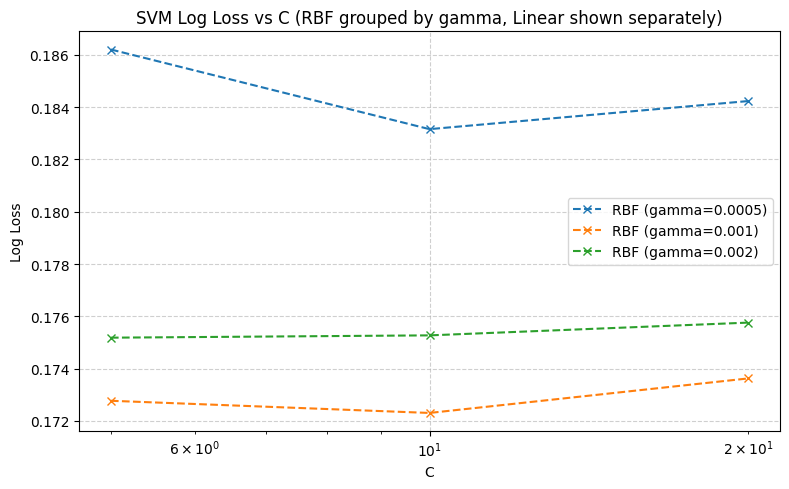

In [61]:
plot_results(res2)

In [62]:
param3 = {
    'svm__kernel': ['rbf'],
    'svm__C': [9, 10, 11],
    'svm__gamma': [0.0009, 0.001, 0.0011]
}

In [63]:
res3 = find_best_params(X_train, y_train, param_grid=param3)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END .......svm__C=9, svm__gamma=0.0009, svm__kernel=rbf; total time=   8.9s
[CV] END .......svm__C=9, svm__gamma=0.0009, svm__kernel=rbf; total time=   8.8s
[CV] END .......svm__C=9, svm__gamma=0.0009, svm__kernel=rbf; total time=   8.7s
[CV] END ........svm__C=9, svm__gamma=0.001, svm__kernel=rbf; total time=   9.0s
[CV] END ........svm__C=9, svm__gamma=0.001, svm__kernel=rbf; total time=   9.1s
[CV] END ........svm__C=9, svm__gamma=0.001, svm__kernel=rbf; total time=   9.3s
[CV] END .......svm__C=9, svm__gamma=0.0011, svm__kernel=rbf; total time=   9.6s
[CV] END .......svm__C=9, svm__gamma=0.0011, svm__kernel=rbf; total time=   9.6s
[CV] END .......svm__C=9, svm__gamma=0.0011, svm__kernel=rbf; total time=   9.3s
[CV] END ......svm__C=10, svm__gamma=0.0009, svm__kernel=rbf; total time=   8.7s
[CV] END ......svm__C=10, svm__gamma=0.0009, svm__kernel=rbf; total time=   8.6s
[CV] END ......svm__C=10, svm__gamma=0.0009, svm_

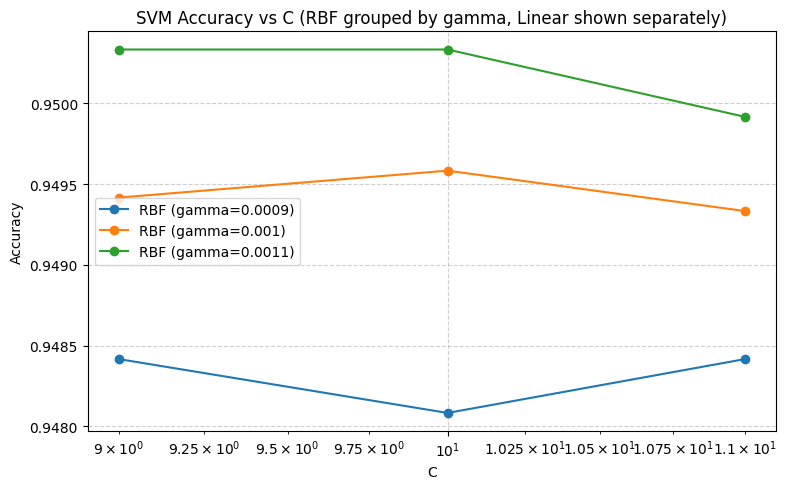

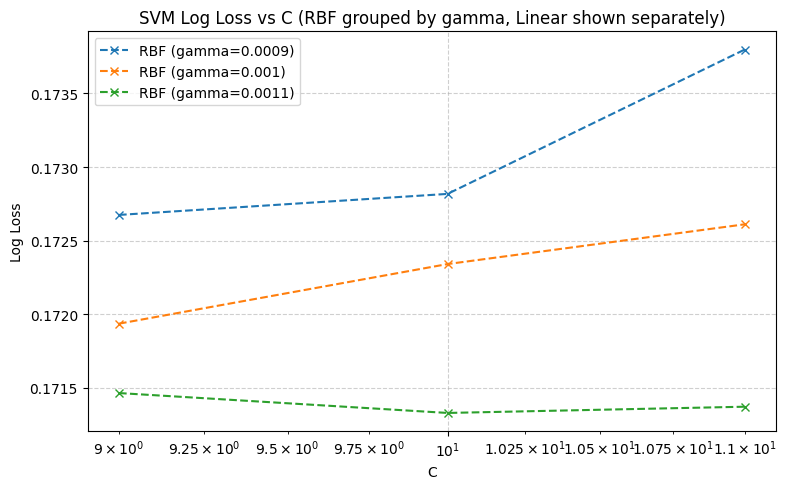

In [64]:
plot_results(res3)

## Testing best hyperparameters:

In [16]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.93)),
    ('svm', SVC(C=9, gamma=0.0011, kernel='rbf', class_weight='balanced'))
])

In [24]:
def test_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.show()

Training
Accuracy: 0.9752


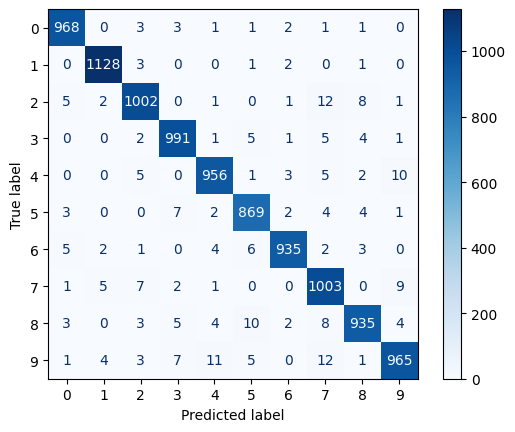

In [25]:
print("Training")
model.fit(X_train, y_train)
test_model(model, X_test=X_test, y_test=y_test)